In [1]:
import os
os.chdir('/home/ubuntu/workspace/hotel_recommender')
print(os.getcwd())
from utils.df_utils import *
from db.database import MyDatabase

from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.df_utils import *
from db.sql_query import get_app_user, get_hotel, get_user_booking
pd.options.display.max_columns = None
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from recommender import HotelRecommender
# Importing dask dataframe
# import dask
# import dask.dataframe as dd
from sklearn.metrics.pairwise import cosine_similarity

# import ray
# ray.init(num_cpus=6, num_gpus=1, ignore_reinit_error=True)
# import modin.pandas as pd  #pip install modin[ray]

# db = MyDatabase()
# save_path = '/home/anhlbt/workspace/hotel_recommender/notebooks/data_recommender/'
save_path = '/home/ubuntu/workspace/hotel_recommender/notebooks/data_recommender/'
import time
from functools import reduce

/home/ubuntu/workspace/hotel_recommender


In [5]:
recommender = HotelRecommender(n_samples=-1)
# recommender.build_model()
# res = recommender.predict(172015) #

In [3]:
# res = recommender.predict(635792) #
# print(res)

In [3]:
"""
Usage:
    $python apriori.py -f DATASET.csv -s minSupport  -c minConfidence
    $python apriori.py -f DATASET.csv -s 0.15 -c 0.6
"""
import os
os.environ["MODIN_ENGINE"] = "dask" 
from asyncio.log import logger
from calendar import c
import sys
import time
from itertools import chain, combinations
from collections import defaultdict
from optparse import OptionParser
from threading import Thread
import time
import pandas as pd
# import modin.pandas as pd 
# Importing dask dataframe
# import dask
# import dask.dataframe as pd
import re
from functools import reduce


class Apriori:
    minSupport = 0
    minConfidence = 0
    def __init__(self, Support, Confidence):
        self.minSupport = Support
        self.minConfidence = Confidence
        
        
    def subsets(self,arr):
        """ Returns non empty subsets of arr"""
        return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])

    def returnItemsWithMinSupport(self,itemSet, transactionList, minSupport, freqSet):
            """calculates the support for items in the itemSet and returns a subset
           of the itemSet each of whose elements satisfies the minimum support"""
            _itemSet = set()
            localSet = defaultdict(int)

            for item in itemSet:
                    for transaction in transactionList:
                            if item.issubset(transaction):
                                    freqSet[item] += 1
                                    localSet[item] += 1

            for item, count in localSet.items():
                    support = float(count)/len(transactionList)

                    if support >= minSupport:#>=
                            _itemSet.add(item)

            return _itemSet


    def joinSet(self,itemSet, length):
            """Join a set with itself and returns the n-element itemsets"""
            return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


    def getItemSetTransactionList(self,data_iterator):
        transactionList = list()
        itemSet = set()
        for record in data_iterator:
            transaction = frozenset(record)
            transactionList.append(transaction)
            for item in transaction:
                itemSet.add(frozenset([item]))              # Generate 1-itemSets
        return itemSet, transactionList


    def runApriori(self,data_iter, minSupport, minConfidence):
        """
        run the apriori algorithm. data_iter is a record iterator
        Return both:
         - items (tuple, support)
         - rules ((pretuple, posttuple), confidence)
        """
        itemSet, transactionList = self.getItemSetTransactionList(data_iter)

        freqSet = defaultdict(int)
        largeSet = dict()
        # Global dictionary which stores (key=n-itemSets,value=support)
        # which satisfy minSupport

        assocRules = dict()
        # Dictionary which stores Association Rules

        oneCSet = self.returnItemsWithMinSupport(itemSet,
                                            transactionList,
                                            minSupport,
                                            freqSet)

        currentLSet = oneCSet
        k = 2
        while(currentLSet != set([])):
            largeSet[k-1] = currentLSet
            currentLSet = self.joinSet(currentLSet, k)
            currentCSet = self.returnItemsWithMinSupport(currentLSet,
                                                    transactionList,
                                                    minSupport,
                                                    freqSet)
            currentLSet = currentCSet
            k = k + 1

        def getSupport(item):
                """local function which Returns the support of an item"""
                return float(freqSet[item])/len(transactionList)

        toRetItems = []
        for key, value in largeSet.items():
            toRetItems.extend([(tuple(item), getSupport(item))
                               for item in value])

        toRetRules = []
        for key, value in largeSet.items():
            for item in value:
                _subsets = map(frozenset, [x for x in self.subsets(item)])
                for element in _subsets:
                    remain = item.difference(element)
                    if len(remain) > 0:
                        confidence = getSupport(item)/getSupport(element)
                        if confidence >= minConfidence:
                            toRetRules.append(((tuple(element), tuple(remain)),
                                               confidence))
        return toRetItems, toRetRules


    def printResults(self, items, rules):
        """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
        for item, support in sorted(items, key=lambda x: x[1]):
            print("item: %s , %.3f" % (str(item), support))
        print("\n------------------------ RULES:")
        for rule, confidence in sorted(rules, key=lambda x: x[1]):
            pre, post = rule
            print("Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence))


    def to_str_results(self, items, rules):
        """prints the generated itemsets sorted by support and the confidence rules sorted by confidence"""
        i, r = [], []
        for item, support in sorted(items, key=lambda x: x[1]):
            x = "item: %s , %.3f" % (str(item), support)
            i.append(x)

        for rule, confidence in sorted(rules, key=lambda x: x[1]):
            pre, post = rule
            x = "Rule: %s ==> %s , %.3f" % (str(pre), str(post), confidence)
            r.append(x)

        return i, r
            
    def saveResults(self,items, rules):
        """save the generated itemsets sorted by support and the confidence rules sorted by confidence"""
        f = open('results.txt', 'w')
        for item, support in sorted(items, key=lambda x: x[1]):
            f.write("\nitem: %s , %.3f" % (str(item), support)) 
        f.write("\n------------------------ RULES:")
        i = 0
        for rule, confidence in sorted(rules, key=lambda x: x[1]):
            pre, post = rule
            i+=1
            f.write("\nRule %s : %s ==> %s , %.3f" % (str(i), str(pre), str(post), confidence)) 

    def dataFromFile(self,fname):
            """Function which reads from the file and yields a generator"""
            file_iter = open(fname, 'rU')
            for line in file_iter:
                    line = line.strip().rstrip(',')                         # Remove trailing comma
                    record = frozenset(line.split(','))
                    yield record

    def dataFromDataFrame(self,df):
        """Function which reads from the file and yields a generator"""
        for index, line in df.iterrows():                    # Remove trailing comma
                record = frozenset(line['booked_hotels'])
                yield record                    




In [4]:

test = Apriori(0.0005, 0.01)
#     inFile = test.dataFromFile('sparse_df.txt')
inFile = test.dataFromDataFrame(recommender.user_lst_hotel.query('count_unique_hotel > 1'))
items, rules = test.runApriori(inFile,test.minSupport,test.minConfidence)


In [5]:
test

In [6]:
recommender.user_lst_hotel.shape

(128281, 4)

In [6]:
def get_results_powerset(list_product, results):   
#     list_cate = list(set(map(lambda x: int(x), list_product.split())))
    list_cate = list_product
    recommend = []
    for item_set in list_powerset(list_cate):
        for index, row in results.iterrows():
            if set(item_set) == set(row.A):
                recommend.extend(row.B)
                print(item_set, row.B)
    return recommend 


# return all subset
def list_powerset(lst):
    return reduce(lambda result, x: result + [subset + [x] for subset in result], lst, [[]])

In [7]:
# items

In [ ]:
test.saveResults(items, rules)

tmp = pd.DataFrame(rules)
tmp1 = pd.DataFrame(list((tmp[0].values)))
tmp1['confidence'] = tmp[1].values
tmp1.columns = ['A', 'B', 'confidence']
tmp1 = tmp1.query('confidence > 0.2')
tmp2 = pd.pivot_table(tmp1, index='A', aggfunc=lambda x: ' '.join(str(v) for v in x))
tmp2 = tmp2.reset_index()
tmp2.B = tmp2['B'].apply(lambda row: [int(float(x)) for x in re.findall(r"\d+\.?\d*", str(row))])
#     add
tmp2.B = tmp2['B'].apply(lambda row: list(set(row)))
tmp2.A = tmp2['A'].apply(lambda row: sorted(list(int(float(x)) for x in row)))

In [ ]:
tmp.shape


In [69]:
for idx, row in recommender.user_lst_hotel.iterrows():
    if 1262 in row['booked_hotels']:
        print(row)

APP_USER_SN                                                       921.0
total_booking                                                        28
count_unique_hotel                                                   20
booked_hotels         [1164, 911, 1177, 11931, 1601, 2754, 2634, 276...
Name: 128, dtype: object
APP_USER_SN                                      2099.0
total_booking                                        13
count_unique_hotel                                    6
booked_hotels         [897, 1058, 1262, 722, 1721, 730]
Name: 328, dtype: object
APP_USER_SN                                                      4815.0
total_booking                                                        25
count_unique_hotel                                                   21
booked_hotels         [1537, 2952, 908, 780, 910, 911, 1040, 1681, 3...
Name: 578, dtype: object
APP_USER_SN                                                      5423.0
total_booking                                        

APP_USER_SN           98428.0
total_booking               9
count_unique_hotel          1
booked_hotels          [1262]
Name: 16679, dtype: object
APP_USER_SN                                                  98491.0
total_booking                                                     23
count_unique_hotel                                                 8
booked_hotels         [4392, 970, 1962, 2541, 1262, 726, 1721, 1052]
Name: 16690, dtype: object
APP_USER_SN                                     100874.0
total_booking                                          9
count_unique_hotel                                     6
booked_hotels         [364, 1262, 910, 1523, 3670, 1439]
Name: 16922, dtype: object
APP_USER_SN                                                   105105.0
total_booking                                                       16
count_unique_hotel                                                   8
booked_hotels         [1380, 3460, 12294, 1130, 1067, 1262, 720, 2067]
Name: 17433

APP_USER_SN                                                140920.0
total_booking                                                     8
count_unique_hotel                                                8
booked_hotels         [1185, 2786, 1514, 875, 780, 1262, 3151, 726]
Name: 24636, dtype: object
APP_USER_SN              142387.0
total_booking                   2
count_unique_hotel              2
booked_hotels         [725, 1262]
Name: 24911, dtype: object
APP_USER_SN                     142777.0
total_booking                          3
count_unique_hotel                     3
booked_hotels         [1105, 2217, 1262]
Name: 24966, dtype: object
APP_USER_SN                                                    143314.0
total_booking                                                        27
count_unique_hotel                                                   17
booked_hotels         [1185, 1537, 1569, 1925, 3045, 1962, 1067, 151...
Name: 25046, dtype: object
APP_USER_SN               147967

APP_USER_SN                                                  201773.0
total_booking                                                      15
count_unique_hotel                                                  8
booked_hotels         [1185, 2467, 4772, 2926, 1262, 1908, 859, 3935]
Name: 41913, dtype: object
APP_USER_SN                                            204058.0
total_booking                                                 7
count_unique_hotel                                            7
booked_hotels         [2659, 806, 2218, 1262, 2067, 3002, 2907]
Name: 42552, dtype: object
APP_USER_SN           206401.0
total_booking                1
count_unique_hotel           1
booked_hotels           [1262]
Name: 43136, dtype: object
APP_USER_SN           206626.0
total_booking                1
count_unique_hotel           1
booked_hotels           [1262]
Name: 43204, dtype: object
APP_USER_SN                                                    207722.0
total_booking                       

APP_USER_SN                                                    419195.0
total_booking                                                        15
count_unique_hotel                                                   11
booked_hotels         [2433, 2754, 1262, 1457, 1681, 1523, 2067, 168...
Name: 77506, dtype: object
APP_USER_SN                                                    420042.0
total_booking                                                         9
count_unique_hotel                                                    9
booked_hotels         [4738, 3370, 4492, 2509, 1262, 2933, 3865, 300...
Name: 77756, dtype: object
APP_USER_SN                                   421550.0
total_booking                                        8
count_unique_hotel                                   5
booked_hotels         [3361, 10533, 1262, 1141, 11931]
Name: 78228, dtype: object
APP_USER_SN                    422227.0
total_booking                         3
count_unique_hotel                    3
boo

APP_USER_SN           596023.0
total_booking                1
count_unique_hotel           1
booked_hotels           [1262]
Name: 112714, dtype: object
APP_USER_SN                            603385.0
total_booking                                14
count_unique_hotel                            4
booked_hotels         [1569, 3460, 12397, 1262]
Name: 113787, dtype: object
APP_USER_SN                                612337.0
total_booking                                     5
count_unique_hotel                                5
booked_hotels         [1003, 1262, 3794, 4596, 823]
Name: 115236, dtype: object
APP_USER_SN                622648.0
total_booking                     2
count_unique_hotel                2
booked_hotels         [12331, 1262]
Name: 116962, dtype: object
APP_USER_SN               629347.0
total_booking                    2
count_unique_hotel               2
booked_hotels         [1938, 1262]
Name: 118228, dtype: object
APP_USER_SN               630361.0
total_booking    

# predict

In [8]:

def get_results_powerset(list_product, results):   
#     list_cate = list(set(map(lambda x: int(x), list_product.split())))
    list_cate = list_product
    recommend = []
    for item_set in list_powerset(list_cate):
        for index, row in results.iterrows():
            if set(item_set) == set(row.A):
                recommend.extend(row.B)
                print(item_set, row.B)
    return recommend 


# return all subset
def list_powerset(lst):
    return reduce(lambda result, x: result + [subset + [x] for subset in result], lst, [[]])


list_product = [2017, 3906, 2856, 3487, 3150, 2223, 945, 3451, 2844, 543]

In [9]:
# list_powerset([2017, 3906, 2856, 3487, 3150, 2223, 945, 3451, 2844, 543])

In [10]:
hotels_of_user = recommender.get_hotels_of_user([405712])

df_hotels_user = recommender.data_hotel.query('SN in @hotels_of_user')[['SN', 'LONGITUDE', 'LATITUDE', 'NAME']]
df_hotels_user['CLUSTER_HDBSCAN'] = 1



hotel_recommend = get_results_powerset(hotels_of_user, tmp2)
df_hotels_recommend = recommender.data_hotel.query('SN in @hotel_recommend')[['SN','LONGITUDE', 'LATITUDE', 'NAME']]
df_hotels_recommend['CLUSTER_HDBSCAN'] = 0


df = pd.concat([df_hotels_user, df_hotels_recommend], axis=0)

NameError: name 'tmp2' is not defined

In [11]:

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10


import folium
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LATITUDE.mean(), df.LONGITUDE.mean()], zoom_start=9, tiles='OpenStreet Map')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[int(row[cluster_column])]

        folium.CircleMarker(
            location= [row['LATITUDE'], row['LONGITUDE']],
            radius=5,
            popup= "{} - {}".format(str(row['SN']), row['NAME']),
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m


# check intersection
#
# [value for value in hotels_of_user if value in hotel_recommend]

k=3
m = create_map(df, 'CLUSTER_HDBSCAN')
print(f'K={k}')
# print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')user_155501user_155501
# m.save('kmeans_70.html')
m

NameError: name 'df' is not defined

In [ ]:
tmp2

# search history

In [ ]:
# sql_7_3 = '''
# select * FROM SEARCH_HISTORY_2022
# where MONTH(SEARCH_TIME) in (1, 2, 3, 4, 5, 6) AND YEAR(SEARCH_TIME) = 2022
# '''
# data_7_3 = db.execute_query(sql_7_3)

In [ ]:
# data_7_3['date'] = data_7_3['SEARCH_TIME'].apply(lambda x: str(x)[:10])
# data_7_3['month'] = data_7_3['SEARCH_TIME'].apply(lambda x: str(x)[5:7])
# data_g_7_3 = data_7_3.groupby(['date']).agg(count_app_user_sn =("APP_USER_SN", pd.Series.nunique)).reset_index()
# data_g_month_7_3  = data_7_3.groupby(['month']).agg(count_app_user_sn =("APP_USER_SN", pd.Series.nunique)).reset_index() #count_= ('SN', count_x)

# key_word = data_7_3.groupby(['KEYWORD']).size().to_frame('count_keyword').reset_index()
# key_word = key_word.sort_values(by='count_keyword', ascending=False)
# file_name = 'request_7_04 Most searched keyword list'.replace(" ", '_').lower()
# # key_word.to_excel(join(save_path, "{}.xlsx".format(file_name)))

In [3]:
# key_word.to_csv(join(save_path, "{}.csv".format(file_name)))
# cleaned_data[['LONGITUDE', 'LATITUDE', 'cluster_label']].to_csv("hotel_clustering.csv", index=False)
# user_booking_pivot = pd.read_csv("df_recommender.csv", index_col='APP_USER_SN')


# Parallel processing

In [3]:
recommender.user_booking.shape

(100000, 13)

In [49]:
# lst_hotel = recommender.get_hotels_by_radius('_10804', radius=1)
# lst_hotel = recommender.get_n_hotels_nearest('_524', hotel_num=50)
lst_hotel = recommender.get_hotels_of_user([313084])

In [50]:
lst_hotel

[1058, 1058, 1058, 1058, 1058, 4517, 4517, 897, 1764]

In [51]:
# centroid of cluster (list hotel by lat long)
centroid = recommender.data_hotel.query("SN in @lst_hotel")[['SN','NAME', 'LONGITUDE', 'LATITUDE']]

In [52]:
centroid

,SN,NAME,LONGITUDE,LATITUDE
759,897,JOY INN CONG HOA HOTEL,106.637284,10.804411
920,1058,ROSE HOTEL,106.689043,10.736888
1626,1764,ĐỨC ĐẠT 2 HOTEL,106.647481,10.839447
4375,4517,BÌNH HƯNG HOTEL,106.659781,10.800329


In [53]:
from sklearn.cluster import OPTICS
import numpy as np


one_person_points_df = centroid[['LATITUDE', 'LONGITUDE']] 
clustering = OPTICS(min_samples = 0.2, max_eps=1, xi = 0.05, metric='haversine') #min_cluster_size=0.2,
one_person_points_df['cluster'] = clustering.fit_predict(np.radians(one_person_points_df[['LATITUDE', 'LONGITUDE']]))


In [57]:
# remove all the observations with cluster -1 (outliers)
one_person_points_df = one_person_points_df[one_person_points_df['cluster'] != -1]
medians_of_POI = one_person_points_df.groupby(['cluster'])[['LATITUDE', 'LONGITUDE']].median().reset_index(drop=False)
medians_of_POI


,cluster,LATITUDE,LONGITUDE
0,0,10.80237,106.653631


<AxesSubplot:>

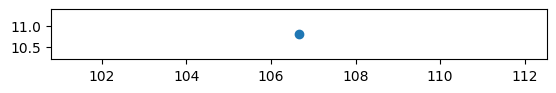

In [58]:
from shapely.geometry.point import Point
import geopandas as gpd

medians_of_POI_gdf = gpd.GeoDataFrame(medians_of_POI, geometry=[Point(x) for x in zip( list(medians_of_POI['LONGITUDE']), list(medians_of_POI['LATITUDE']))])
medians_of_POI_gdf.plot()


<AxesSubplot:>

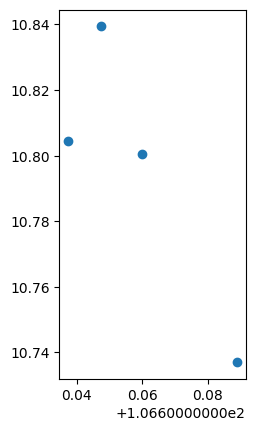

In [59]:

data = gpd.GeoDataFrame(one_person_points_df, geometry=[Point(x) for x in zip( list(one_person_points_df['LONGITUDE']), list(one_person_points_df['LATITUDE']))])
data.plot()

<AxesSubplot:>

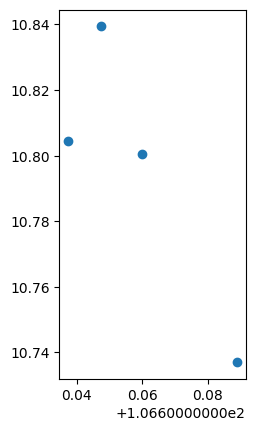

In [61]:

data2 = gpd.GeoDataFrame(centroid, geometry=[Point(x) for x in zip( list(centroid['LONGITUDE']), list(centroid['LATITUDE']))])
data2.plot()

In [62]:
import hdbscan


X = np.array(one_person_points_df[['LONGITUDE', 'LATITUDE']], dtype='float64')
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.05, )
#min_cluster_size
#min_samples
#cluster_slection_epsilon

class_predictions = model.fit_predict(X)
one_person_points_df['CLUSTER_HDBSCAN'] = class_predictions

In [63]:
#calculate median of user

df = one_person_points_df[one_person_points_df['CLUSTER_HDBSCAN'] >= 0]
medians_of_user = df.groupby(['CLUSTER_HDBSCAN'])[['LATITUDE', 'LONGITUDE']].median().reset_index(drop=False)
medians_of_user

,CLUSTER_HDBSCAN


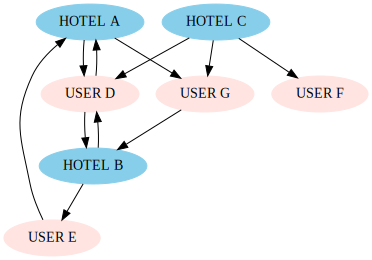

In [117]:
import graphviz

f = graphviz.Digraph(filename = "./data_recommender/filled_colorful_organogram.gv")


names = ["HA","HB","HC","UD","UE","UF","UG"]

positions = ["HOTEL A","HOTEL B", "HOTEL C", "USER D","USER E", "USER F", "USER G"]

colors = ["skyblue", "skyblue", "skyblue", "mistyrose", "mistyrose", "mistyrose", "mistyrose"]

for name, position, color in zip(names, positions, colors):
    f.node(name, position, style = "filled", color = color)
    
#Specify edges
f.edge("HA","UD"); f.edge("HA","UG") ; f.edge("HC", "UD")
f.edge("HB","UD"); f.edge("HB","UE")
f.edge("HC","UF"); f.edge("HC","UG");
f.edge("UE","HA"); f.edge("UG","HB")
f.edge("UD","HA"); f.edge("UD","HB")
    
f

In [21]:
f.view()

'data_recommender/filled_colorful_organogram.gv.pdf'

In [ ]:
# import hashlib
  

# str2hash = 'hello'
  
# result = hashlib.md5(str2hash.encode())
  
# # printing the equivalent hexadecimal value.
# print("The hexadecimal equivalent of hash is : ", end ="")
# print(result.hexdigest())

# visual with networkx 

In [166]:
import plotly.graph_objects as go

import networkx as nx

In [168]:


hotel_booking.head(3)

,HOTEL_SN,count_unique_user,total_booked,booked_users
0,169,2,2,"631241, 573865"
1,175,2,2,"410551, 470558"
2,183,8,10,"24589, 578782, 499132, 535998, 531403, 578782,..."


In [171]:

list(map(int, hotel_booking.loc[0,'booked_users'].split(',')))

[631241, 573865]

In [174]:
G = nx.Graph((raw['HOTEL_SN'], user, {'weight': raw['total_booked'], 'label':str(raw['total_booked'])}) \
             for index, raw in hotel_booking.iterrows() \
                for user in list(map(int, raw['booked_users'].split(','))) \
            )


In [182]:
nodes = filter(lambda n, d: d['color'] == 'red', G.nodes(data=True))

In [178]:
for node in G.nodes():
    print(node)
    

169
631241
573865
175
410551
470558
183
24589
578782
499132
535998
531403
3561
467432
0
184
299133
167989
510372
555263
539211
145108
395615
164415
145544
418280
164201
201839
127670
149714
525347
527990
631267
199112
235931
528826
609985
625266
304122
238
364
586216
29866
575695
570374
376493
361734
465
482
261173
303097
458512
470651
420871
488146
2073
160558
444265
434737
567953
212798
546411
468009
31380
161770
474761
9380
468074
434051
554376
475560
457778
425360
390908
75473
189162
630288
89479
411166
540694
511322
245129
506338
548731
384550
19983
310409
179463
395297
541683
513511
444840
485
188451
513543
145398
589426
578156
630904
477361
497181
382712
47709
424243
292379
168363
448330
517469
606437
420542
591442
525656
431512
118602
493937
32223
117200
459765
418321
28822
566254
541714
587492
611356
92125
316203
455263
21413
489712
441819
404100
452571
436565
288996
479486
405931
73407
541914
475743
392032
537127
506
85389
512
296399
516
521
586613
155090
183541
570969
631531

In [176]:
G.nodes

NodeView((169, 631241, 573865, 175, 410551, 470558, 183, 24589, 578782, 499132, 535998, 531403, 3561, 467432, 0, 184, 299133, 167989, 510372, 555263, 539211, 145108, 395615, 164415, 145544, 418280, 164201, 201839, 127670, 149714, 525347, 527990, 631267, 199112, 235931, 528826, 609985, 625266, 304122, 238, 364, 586216, 29866, 575695, 570374, 376493, 361734, 465, 482, 261173, 303097, 458512, 470651, 420871, 488146, 2073, 160558, 444265, 434737, 567953, 212798, 546411, 468009, 31380, 161770, 474761, 9380, 468074, 434051, 554376, 475560, 457778, 425360, 390908, 75473, 189162, 630288, 89479, 411166, 540694, 511322, 245129, 506338, 548731, 384550, 19983, 310409, 179463, 395297, 541683, 513511, 444840, 485, 188451, 513543, 145398, 589426, 578156, 630904, 477361, 497181, 382712, 47709, 424243, 292379, 168363, 448330, 517469, 606437, 420542, 591442, 525656, 431512, 118602, 493937, 32223, 117200, 459765, 418321, 28822, 566254, 541714, 587492, 611356, 92125, 316203, 455263, 21413, 489712, 441819,

In [128]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: 'pos'

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https:///'> GOOGLE.COM</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# get list booked user

In [ ]:
# db = MyDatabase()
# sql_test = '''
# select APP_USER_SN, count(*) AS TOTAL_BOOKING
# from USER_BOOKING
# GROUP BY APP_USER_SN
# '''
# db.execute_query(sql_test)

In [45]:
recommender.user_lst_hotel

,APP_USER_SN,total_booking,count_unique_hotel,booked_hotels
0,15.0,3,3,"[834, 2964, 757]"
1,20.0,1,1,[464]
2,29.0,1,1,[468]
3,32.0,1,1,[479]
4,40.0,1,1,[478]
...,...,...,...,...
119638,637051.0,1,1,[3865]
119639,637054.0,1,1,[12848]
119640,637060.0,1,1,[1268]
119641,637080.0,1,1,[653]
